# Deep reinforcement learning applied to the monte carlo paths

In [ ]:
import numpy as np
from scipy.linalg import eig, inv, cholesky
from OU_simulation import *
from Policy_Gradient_agent import *
from TD3 import *
import matplotlib.pyplot as plt
from tqdm import tqdm
from scipy.integrate import odeint
%reload_ext autoreload
%autoreload 2

In [ ]:
# Same parameters are used as in the paper 
N       = 1
T       = 40
L       = 1000
delta_t = T/L
theta   = np.diag(np.random.normal(0.5, 0.1, N))
mu      = np.zeros((N,1))
sigma   = np.random.uniform(-0.3,0.3,(N,N))
sigma   = sigma - np.diag(sigma.diagonal()) + np.diag(np.random.uniform(0,0.5,N))

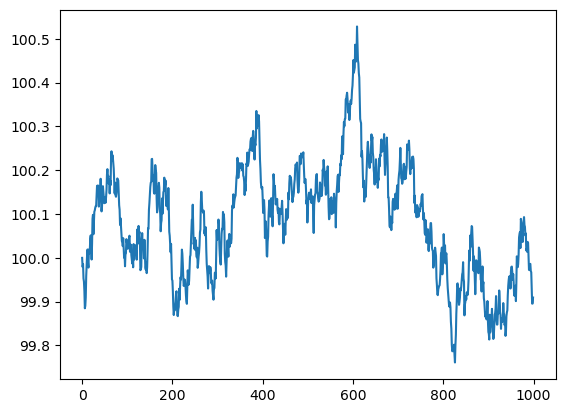

In [ ]:
p = np.ones(N)
process  = ornstein_uhlenbeck_process(theta,mu,sigma,delta_t)
test_env = TradingEnvironment(process,T,0,p, mode='portfolio')
test_env.reset()

done = False
while not done:
    state, reward, done, _ = test_env.step(np.ones(N))
plt.plot(test_env.W.transpose())

In [ ]:
r  = 0.02 # 0.2% interest rate
p  = np.ones((N,1)) #simplification in this model the asset prices themselves are assumed to be mean reverting
M  = 100 # amount of monte carlo simulations done
W0 = 0
process = ornstein_uhlenbeck_process(theta,mu,sigma,delta_t)
env     = TradingEnvironment(process,T,r,p)

def init_weights(m):
    """ Initializes the ANNs weights with a relevant distribution. """
    if type(m) == nn.Linear:
        torch.nn.init.xavier_normal_(m.weight)
        #m.bias.data.fill_(0)

#### 3.1 Actor-Critic reinforcement learning 

First the policy and value models need to be created 

C-RL converges for 1 asset with hidden_dim=5 and learning_rate= 0.003
but does not converge for 100 assets with hidden_dim=500 and learning rate =0.0003

In [ ]:
LEARNING_RATE = 0.03
MAX_EPISODES = 300
DISCOUNT_FACTOR = 0
N_TRIALS = 25

INPUT_DIM  = N#2 * N + 1# first N input values is X_t and the next is pi_t
HIDDEN_DIM = 5
OUTPUT_DIM_ACTOR = N
OUTPUT_DIM_CRITIC = 1

policy_losses = []
value_losses = []
train_rewards = []
test_rewards = []

# init agent
actor = PolicyModel(INPUT_DIM, HIDDEN_DIM, OUTPUT_DIM_ACTOR)
critic = ValueModel(INPUT_DIM, HIDDEN_DIM, OUTPUT_DIM_CRITIC)
agent = ActorCritic(actor, critic)

agent.apply(init_weights)
optimizer = optim.Adam(agent.parameters(), lr = LEARNING_RATE)

process = ornstein_uhlenbeck_process(theta,mu,sigma,delta_t)
train_env = TradingEnvironment(process,T,r,p)
train_env.eval()
eval_env = TradingEnvironment(process,T,r,p)
eval_env.eval()

for episode in range(1, MAX_EPISODES+1):
    policy_loss, value_loss, train_reward = train(train_env, agent, optimizer, DISCOUNT_FACTOR)
    test_reward = evaluate(eval_env, agent, False)
    
    train_rewards.append(train_reward)
    test_rewards.append(test_reward)
    policy_losses.append(policy_loss)
    value_losses.append(value_loss)
    
    mean_train_rewards = np.mean(train_rewards[-N_TRIALS:])
    mean_test_rewards = np.mean(test_rewards[-N_TRIALS:])
    
    plot(episode, train_rewards, policy_losses, value_losses)

NameError: name 'N' is not defined

#### 3.2 Proximal Policy Optimisation (PPO)

Using only $X_t$ as a state feature and $\alpha$ = 0

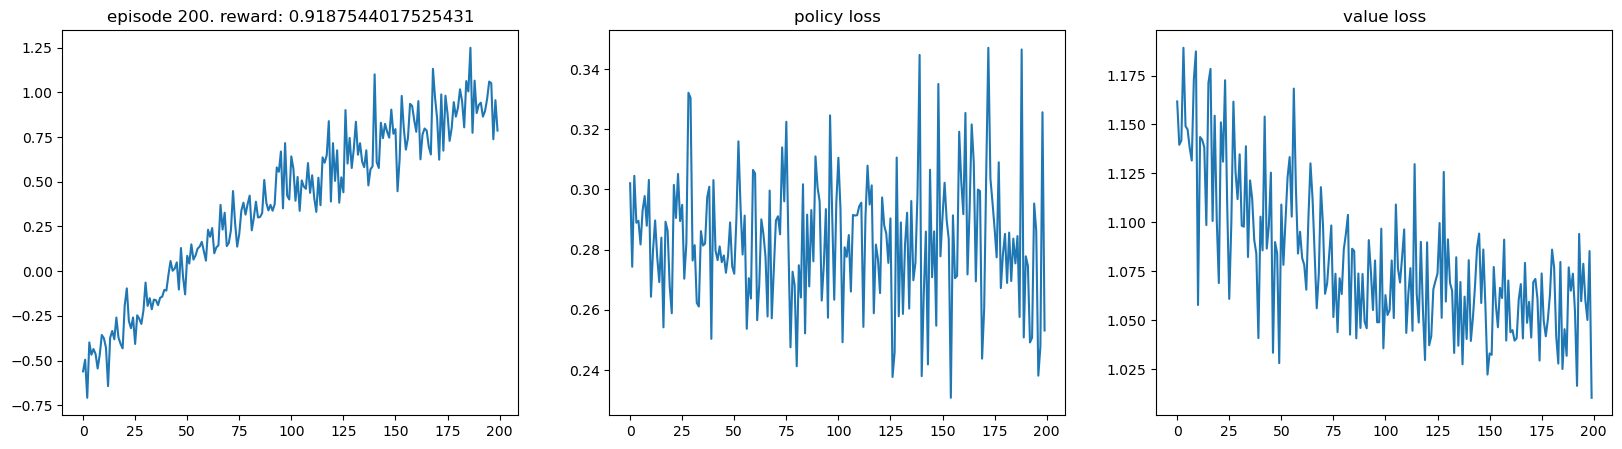

In [ ]:
MAX_EPISODES = 200
LEARNING_RATE = 0.0001
DISCOUNT_FACTOR = 0.0
N_TRIALS = 25
PPO_STEPS = 5
PPO_CLIP = 0.2

INPUT_DIM  = N # first N input values is X_t and the next is pi_t
HIDDEN_DIM = 50  #2*N+1
OUTPUT_DIM_ACTOR = N
OUTPUT_DIM_CRITIC = 1

policy_losses = []
value_losses = []
train_rewards = []
test_rewards = []

process = ornstein_uhlenbeck_process(theta,mu,sigma,delta_t)
r = 0
train_env = TradingEnvironment(process,T,r,p,mode='portfolio', max_pi=10, max_change=5)
eval_env = TradingEnvironment(process,T,r,p,mode='portfolio', max_pi=10, max_change=5)

# init agent
actor = PolicyModel(INPUT_DIM, HIDDEN_DIM, OUTPUT_DIM_ACTOR,dropout=0.3)
critic = ValueModel(INPUT_DIM, HIDDEN_DIM, OUTPUT_DIM_CRITIC, dropout=0.3)
agent = ActorCritic(actor, critic)
agent.apply(init_weights)
optimizer = optim.Adam(agent.parameters(), lr = LEARNING_RATE)
scheduler = optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.99)

for episode in range(1, MAX_EPISODES+1):
    
    policy_loss, value_loss, train_reward = train_ppo(train_env, agent, optimizer,scheduler, DISCOUNT_FACTOR, PPO_STEPS, PPO_CLIP)
    
    test_reward = evaluate(eval_env, agent)
    
    train_rewards.append(train_reward)
    test_rewards.append(test_reward)
    policy_losses.append(policy_loss)
    value_losses.append(value_loss)

    
    mean_train_rewards = np.mean(train_rewards[-N_TRIALS:])
    mean_test_rewards = np.mean(test_rewards[-N_TRIALS:])
    
    plot(episode, test_rewards, policy_losses, value_losses)

Text(0.5, 1.0, 'sample path of $W_t$')

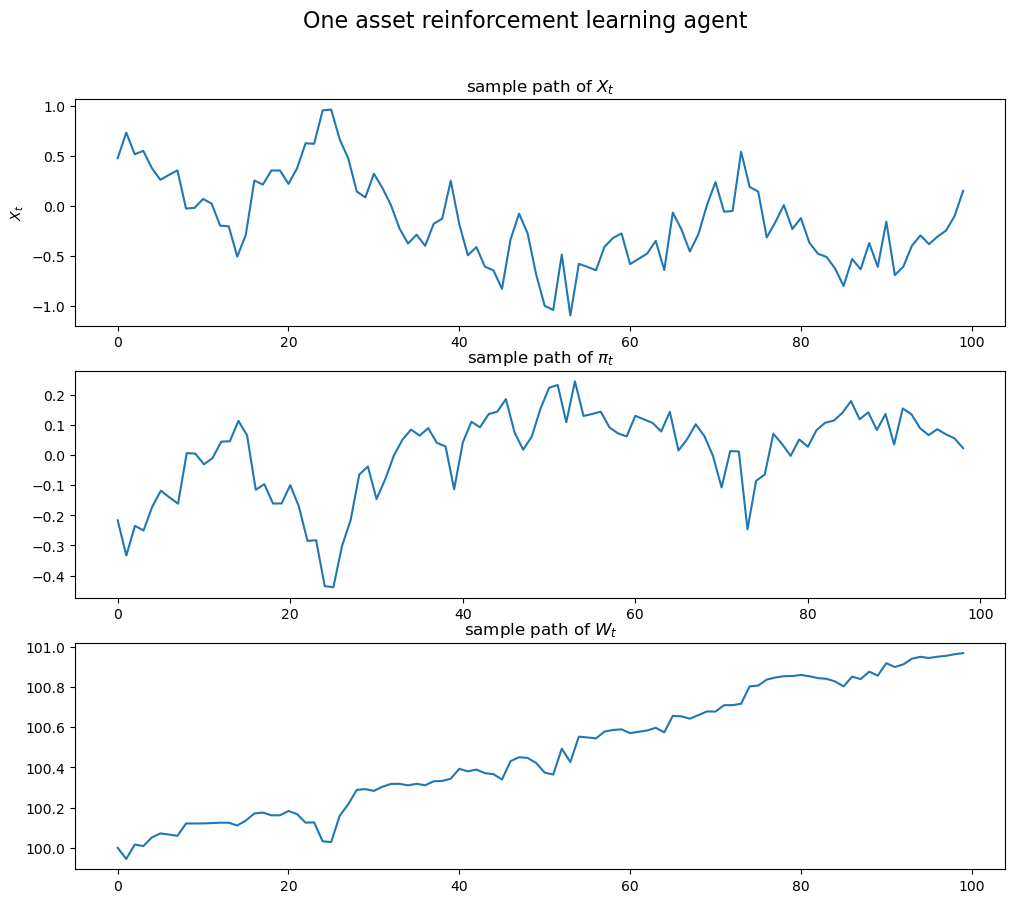

In [ ]:
state,_ = train_env.reset()
done = False
val_predictions = []
while not done:
    state = torch.FloatTensor(state['values']).unsqueeze(0)
    action, _, value_pred = agent.forward(state)
    val_predictions.append(value_pred.detach().item())
    state, reward, done, _ = train_env.step(action.detach().numpy())
    
fig, ax = plt.subplots(3,1,figsize=(12,10))
fig.suptitle('One asset reinforcement learning agent', fontsize=16, y = 0.97)
# plot a sample path of the wealth
ax[0].plot(train_env.X.transpose())
ax[0].set_title(r'sample path of $X_t$')
ax[0].set_ylabel(r'$X_t$')
#ax[0].set_xlabel('Time')
ax[1].plot(np.array(train_env.alloc).sum(axis=1).reshape(-1))
ax[1].set_title(r'sample path of $\pi_t$')

ax[2].plot(train_env.W)
ax[2].set_title(r'sample path of $W_t$')


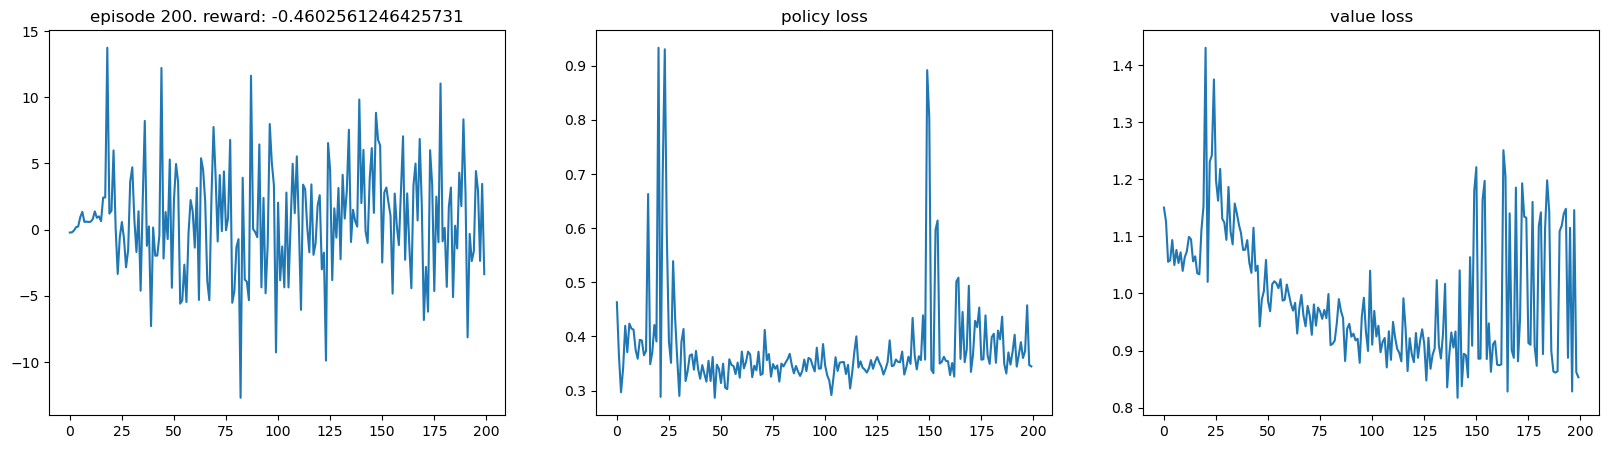

In [ ]:
MAX_EPISODES = 200
LEARNING_RATE = 0.0001
DISCOUNT_FACTOR = 0.99
N_TRIALS = 25
PPO_STEPS = 10
PPO_CLIP = 0.1

INPUT_DIM  = 2*N # first N input values is X_t and the next is pi_t
HIDDEN_DIM = 100  #2*N+1
OUTPUT_DIM_ACTOR = N
OUTPUT_DIM_CRITIC = 1

policy_losses = []
value_losses = []
train_rewards = []
test_rewards = []

process = ornstein_uhlenbeck_process(theta,mu,sigma,delta_t)
r = 0
train_env = TradingEnvironment(process,T,r,p,mode='intensity', max_pi=10, max_change=5)
eval_env = TradingEnvironment(process,T,r,p,mode='intensity', max_pi=10, max_change=5)

# init agent
actor = PolicyModel(INPUT_DIM, HIDDEN_DIM, OUTPUT_DIM_ACTOR,dropout=0.3)
critic = ValueModel(INPUT_DIM, HIDDEN_DIM, OUTPUT_DIM_CRITIC, dropout=0.3)
agent = ActorCritic(actor, critic)
agent.apply(init_weights)
optimizer = optim.Adam(agent.parameters(), lr = LEARNING_RATE)
scheduler = optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.99)

for episode in range(1, MAX_EPISODES+1):
    
    policy_loss, value_loss, train_reward = train_ppo(train_env, agent, optimizer,scheduler, DISCOUNT_FACTOR, PPO_STEPS, PPO_CLIP)
    
    test_reward = evaluate(eval_env, agent)
    
    train_rewards.append(train_reward)
    test_rewards.append(test_reward)
    policy_losses.append(policy_loss)
    value_losses.append(value_loss)

    
    mean_train_rewards = np.mean(train_rewards[-N_TRIALS:])
    mean_test_rewards = np.mean(test_rewards[-N_TRIALS:])
    
    plot(episode, test_rewards, policy_losses, value_losses)

Text(0.5, 1.0, 'sample path of $W_t$')

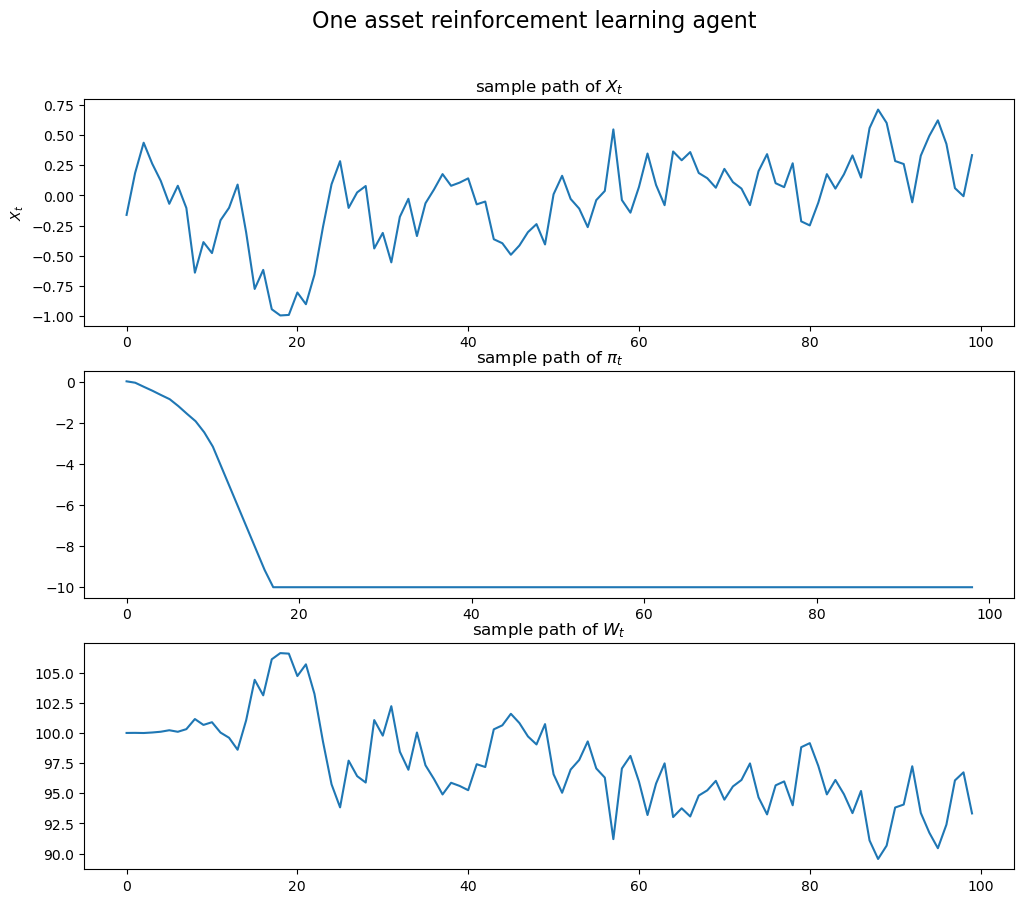

In [ ]:
state, _ = train_env.reset()
done = False
val_predictions = []
while not done:
    #state = torch.FloatTensor(state[:N]).unsqueeze(0)
    state = torch.cat((torch.FloatTensor(state['values']),torch.FloatTensor(state['portfolio']))).unsqueeze(0)


    action, _, value_pred = agent.forward(state)
    val_predictions.append(value_pred.detach().item())
    state, reward, done, _ = train_env.step(action.detach().numpy())
    
fig, ax = plt.subplots(3,1,figsize=(12,10))
fig.suptitle('One asset reinforcement learning agent', fontsize=16, y = 0.97)
# plot a sample path of the wealth
ax[0].plot(train_env.X.transpose())
ax[0].set_title(r'sample path of $X_t$')
ax[0].set_ylabel(r'$X_t$')
#ax[0].set_xlabel('Time')
ax[1].plot(np.array(train_env.alloc).sum(axis=1).reshape(-1))
ax[1].set_title(r'sample path of $\pi_t$')

ax[2].plot(train_env.W)
ax[2].set_title(r'sample path of $W_t$')

#### 3.2 twin delayed deep deterministic policy gradient (TD3)

In [ ]:
import numpy as np
import torch
import os
from TD3 import *

# PARAMETERS
seed = 100
alpha = 0.99 # Discount factor
tau  = 0.005 # Target network update rate

p = np.ones(N)
process = ornstein_uhlenbeck_process(theta,mu,sigma,delta_t)
#N = 1
#process = OU_process_shuffler(N,T,L)
r = 0.0
tc = 0.0
env = TradingEnvironment(process,T,r,p,mode='intensity', max_pi=100, max_change=20,initial_wealth=0, transaction_costs=tc)

HIDDEN_DIM = 16

POLICY_NOISE =  0.2 # Noise added to target policy during critic update
MAX_ACTION = 20
POLICY_FREQ = 2 # Frequency of delayed policy updates
MAX_TIMESTEPS = 100000 # Max time steps to run environment
EXPL_NOISE = 0.1 # Std of Gaussian exploration noise
START_TIMESTEPS = 25e3 # Time steps initial random policy is used
NOISE_CLIP =  0.5 # Range to clip target policy noise
BATCH_SIZE = 256 # Batch size for both actor and critic
EVAL_FREQ = 5e3  # How often (time steps) we evaluate

SAVE_MODEL = True
file_name = 'N1'

# Set seeds
env.seed(seed)
env.action_space.seed(seed)
torch.manual_seed(seed)
np.random.seed(seed)

state_dim = 2*N # env.observation_space.shape[0]
action_dim = env.action_space.shape[0] 
max_action = float(env.action_space.high[0])

kwargs = {
    "state_dim": state_dim,
    "action_dim": action_dim,
    "max_action": max_action,
    "discount": alpha,
    "tau": tau,
    'hidden_dimension': HIDDEN_DIM
}

# Initialize policy
kwargs["policy_noise"] = POLICY_NOISE * MAX_ACTION
kwargs["noise_clip"] = NOISE_CLIP * MAX_ACTION
kwargs["policy_freq"] = POLICY_FREQ
policy = TD3(**kwargs)

#policy.load(f"./models/{policy_file}")

replay_buffer = ReplayBuffer_TD3(state_dim, action_dim)

# Evaluate untrained policy
evaluations = [eval_policy(policy, env, seed)]

state,_ = env.reset()
state = dict_to_features(state)

done   = False
episode_reward = 0
episode_timesteps = 0
episode_num = 0

for t in range(int(MAX_TIMESTEPS)):
    
    episode_timesteps += 1

    # Select action randomly or according to policy
    if t < START_TIMESTEPS:
        action = env.action_space.sample()
    else:
        action = (
            policy.select_action(np.array(state))
            + np.random.normal(0, MAX_ACTION * EXPL_NOISE, size=action_dim)
        ).clip(-max_action, max_action)

    # Perform action
    next_state, reward, done, _ = env.step(action)
    next_state = dict_to_features(next_state)
    #done_bool = float(done) if episode_timesteps < env.L else 0
    done_bool = float(done)
    # Store data in replay buffer
    replay_buffer.add(state, action, next_state, reward, done_bool)

    state = next_state
    episode_reward += reward

    # Train agent after collecting sufficient data
    if t >= START_TIMESTEPS:
        policy.train(replay_buffer, BATCH_SIZE)

    if done: 
        # +1 to account for 0 indexing. +0 on ep_timesteps since it will increment +1 even if done=True
        print(f"Total T: {t+1} Episode Num: {episode_num+1} Episode T: {episode_timesteps} Reward: {episode_reward:.3f}")
        # Reset environment
        state,_ = env.reset()
        done  = False
        state = dict_to_features(state)
        episode_reward = 0
        episode_timesteps = 0
        episode_num += 1 

    # Evaluate episode
    if (t + 1) % EVAL_FREQ == 0:
        evaluations.append(eval_policy(policy, env, seed))
        env.reset()
        np.save(f"{os.getcwd()}/results/{file_name}", evaluations)
        if SAVE_MODEL: policy.save(f"{os.getcwd()}/models/{file_name}")

---------------------------------------
Evaluation over 10 episodes: -0.578
---------------------------------------
Total T: 999 Episode Num: 1 Episode T: 999 Reward: -22.955
Total T: 1998 Episode Num: 2 Episode T: 999 Reward: 23.332
Total T: 2997 Episode Num: 3 Episode T: 999 Reward: 14.289
Total T: 3996 Episode Num: 4 Episode T: 999 Reward: 11.897
Total T: 4995 Episode Num: 5 Episode T: 999 Reward: 10.591
---------------------------------------
Evaluation over 10 episodes: -3.408
---------------------------------------
Total T: 5999 Episode Num: 6 Episode T: 1004 Reward: -18.365
Total T: 6998 Episode Num: 7 Episode T: 999 Reward: -12.078
Total T: 7997 Episode Num: 8 Episode T: 999 Reward: 58.634
Total T: 8996 Episode Num: 9 Episode T: 999 Reward: 6.736
Total T: 9995 Episode Num: 10 Episode T: 999 Reward: 6.377
---------------------------------------
Evaluation over 10 episodes: 0.599
---------------------------------------
Total T: 10999 Episode Num: 11 Episode T: 1004 Reward: 31.683

Text(0.5, 1.0, 'sample path of $W_t$')

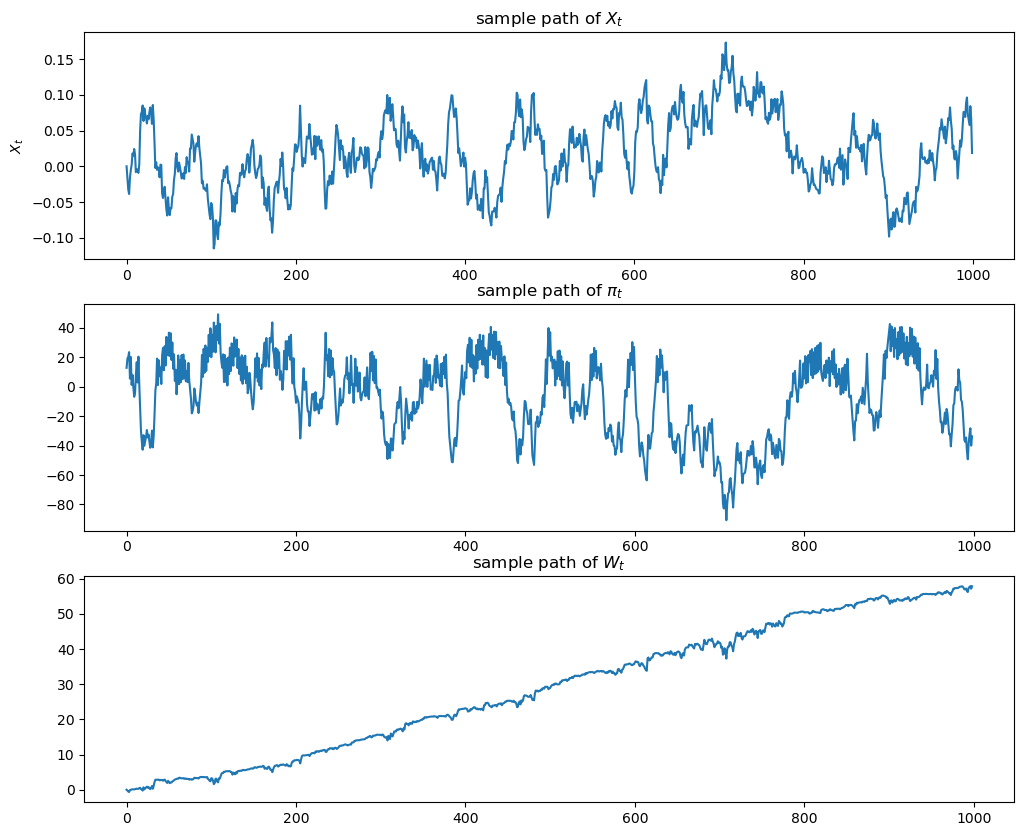

In [ ]:
state, _ = env.reset()
done = False
val_predictions = []
while not done:
    #state = torch.FloatTensor(state[:N]).unsqueeze(0)
    state = dict_to_features(state)

    action = policy.select_action(np.array(state))
    #val_predictions.append(value_pred.detach().item())
    state, reward, done, _ = env.step(action)
    
fig, ax = plt.subplots(3,1,figsize=(12,10))
#fig.suptitle(fr'One asset reinforcement learning agent $\theta$: {env.process.theta.item()}, $\sigma$: {env.process.sigma.item()}', fontsize=16, y = 0.97)
# plot a sample path of the wealth
ax[0].plot(env.X.transpose())
ax[0].set_title(r'sample path of $X_t$')
ax[0].set_ylabel(r'$X_t$')
#ax[0].set_xlabel('Time')
ax[1].plot(np.array(env.alloc).sum(axis=1).reshape(-1))
ax[1].set_title(r'sample path of $\pi_t$')

ax[2].plot(env.W[:-1])
ax[2].set_title(r'sample path of $W_t$')

3.2 Adding a vision transformer to the agent 

In [ ]:
class CNN_Block(nn.Module):
    def __init__(self, in_filters=1, out_filters=8, normalization=True, filter_size=2):
        super(CNN_Block, self).__init__()  
        self.in_filters = in_filters
        self.out_filters = out_filters
        
        self.conv1 = nn.Conv1d(in_channels=in_filters, out_channels=out_filters, kernel_size=filter_size,
                                    stride=1, padding=0, dilation=1, groups=1, bias=True, padding_mode='zeros')
        self.conv2 = nn.Conv1d(in_channels=out_filters, out_channels=out_filters, kernel_size=filter_size,
                                    stride=1, padding=0, dilation=1, groups=1, bias=True, padding_mode='zeros')
        self.relu = nn.ReLU(inplace=True)
        self.left_zero_padding = nn.ConstantPad1d((filter_size-1,0),0)
        
        self.normalization1 = nn.InstanceNorm1d(in_filters)
        self.normalization2 = nn.InstanceNorm1d(out_filters)
        self.normalization = normalization
       
    def forward(self, x): #x and out have dims (N,C,T) where C is the number of channels/filters
        if self.normalization:
            x = self.normalization1(x)
        out = self.left_zero_padding(x)
        out = self.conv1(out)
        out = self.relu(out)
        if self.normalization: 
            out = self.normalization2(out)
        out = self.left_zero_padding(out)
        out = self.conv2(out)
        out = self.relu(out)
        out = out + x.repeat(1,int(self.out_filters/self.in_filters),1)   
        return out 

class CNNTransformer(nn.Module):
    def __init__(self, 
                 random_seed = 0, 
                 device = "cpu", # other options for device are e.g. "cuda:0"
                 normalization_conv = True, 
                 filter_numbers = [1,8], 
                 attention_heads = 4, 
                 use_convolution = True,
                 hidden_units = 2*8, 
                 hidden_units_factor = 2,
                 dropout = 0.25, 
                 filter_size = 2, 
                 use_transformer = True):
        
        super(CNNTransformer, self).__init__()
        if hidden_units and hidden_units_factor and hidden_units != hidden_units_factor * filter_numbers[-1]:
            raise Exception(f"`hidden_units` conflicts with `hidden_units_factor`; provide one or the other, but not both.")
        if hidden_units_factor:
            hidden_units = hidden_units_factor * filter_numbers[-1]
        #self.logdir = logdir
        self.random_seed = random_seed 
        torch.manual_seed(self.random_seed)
        self.device = torch.device(device)
        self.filter_numbers = filter_numbers
        self.use_transformer = use_transformer
        self.use_convolution = use_convolution and len(filter_numbers) > 0
        self.is_trainable = True
        
        self.convBlocks = nn.ModuleList()
        for i in range(len(filter_numbers)-1):
            self.convBlocks.append(
                CNN_Block(filter_numbers[i],filter_numbers[i+1],normalization=normalization_conv,filter_size=filter_size))
        self.encoder = nn.TransformerEncoderLayer(d_model=filter_numbers[-1], nhead=attention_heads, dim_feedforward=hidden_units, dropout=dropout)
        self.linear = nn.Linear(filter_numbers[-1],1)
        #self.softmax = nn.Sequential(nn.Linear(filter_numbers[-1],num_classes))#,nn.Softmax(dim=1))
                 
    def forward(self,x): #x has dimension (N,T)
        N,T = x.shape # TODO: werkt dit hetzelfde onder batch en gewoon??
        #N = 1
        #T = len(x)
        x = x.reshape((N,1,T))  #(N,1,T)
        if self.use_convolution:
            for i in range(len(self.filter_numbers)-1):
                x = self.convBlocks[i](x) #(N,C,T), C is the number of channels/features
        x = x.permute(2,0,1)
        if self.use_transformer:
            x = self.encoder(x) #the input of the transformer is (T,N,C)
        return self.linear(x[-1,:,:]).squeeze() #this outputs the weights #self.softmax(x[-1,:,:]) #(N,num_classes)

class Actor_ViT(nn.Module):
	def __init__(self, action_dim, max_action, hidden_dimension, vision_transformer):
		super(Actor_ViT, self).__init__()

		self.ViT = vision_transformer
		self.l2 = nn.Linear(2, hidden_dimension)
		self.l3 = nn.Linear(hidden_dimension, action_dim)
		
		self.max_action = max_action
		
	def forward(self, state):
		extr_features = self.ViT(state[:,:-1]) #  outputs a scalar
		processed_state = torch.cat([extr_features.reshape(-1,1), state[:,-1].reshape(-1,1)],1)
		a = F.relu(self.l2(processed_state))
		return self.max_action * torch.tanh(self.l3(a))

class Critic_ViT(nn.Module):
    def __init__(self, action_dim, hidden_dimension, vision_transformer):
        super(Critic_ViT, self).__init__()

        # Q1 architecture
        self.ViT = vision_transformer
        self.l1 = nn.Linear(2 + action_dim, hidden_dimension)
        self.l3 = nn.Linear(hidden_dimension, 1)

        # Q2 architecture
        self.l4 = nn.Linear(2 + action_dim, hidden_dimension)
        self.l6 = nn.Linear(hidden_dimension, 1)

    def forward(self, state, action):
        extr_features = self.ViT(state[:,:-1]) #  outputs a scalar
        processed_state = torch.cat([extr_features.reshape(-1,1), state[:,-1].reshape(-1,1)],1)

        sa = torch.cat([processed_state, action], 1)

        q1 = F.relu(self.l1(sa))
        q1 = self.l3(q1)

        q2 = F.relu(self.l4(sa))
        q2 = self.l6(q2)
        return q1, q2

    def Q1(self, state, action):
        extr_features = self.ViT(state[:,:-1]) #  outputs a scalar
        processed_state = torch.cat([extr_features.reshape(-1,1), state[:,-1].reshape(-1,1)],1)

        sa = torch.cat([processed_state, action], 1)

        q1 = F.relu(self.l1(sa))
        q1 = self.l3(q1)
        return q1

In [ ]:
device = 'cpu'
class TD3_ViT(object):
	def __init__(
		self,
		action_dim,
		max_action,
		discount=0.99,
		tau=0.005,
		policy_noise=0.2,
		noise_clip=0.5,
		policy_freq=2,
		hidden_dimension = 256
	):
		self.feature_extractor = CNNTransformer(hidden_units=hidden_dimension)
		self.actor = Actor_ViT(action_dim, max_action,hidden_dimension, self.feature_extractor).to(device)
		self.actor_target = copy.deepcopy(self.actor)
		self.actor_optimizer = torch.optim.Adam(self.actor.parameters(), lr=3e-4)

		self.critic = Critic_ViT(action_dim, hidden_dimension,self.feature_extractor).to(device)
		self.critic_target = copy.deepcopy(self.critic)
		self.critic_optimizer = torch.optim.Adam(self.critic.parameters(), lr=3e-4)

		self.max_action = max_action
		self.discount = discount
		self.tau = tau
		self.policy_noise = policy_noise
		self.noise_clip = noise_clip
		self.policy_freq = policy_freq

		self.total_it = 0


	def select_action(self, state):
		state = torch.FloatTensor(state.reshape(1, -1)).to(device)
		return self.actor(state).cpu().data.numpy().flatten()


	def train(self, replay_buffer, batch_size=256):
		self.total_it += 1

		# Sample replay buffer 
		state, action, next_state, reward, not_done = replay_buffer.sample(batch_size)

		with torch.no_grad():
			# Select action according to policy and add clipped noise
			noise = (
				torch.randn_like(action) * self.policy_noise
			).clamp(-self.noise_clip, self.noise_clip)
			
			next_action = (
				self.actor_target(next_state) + noise
			).clamp(-self.max_action, self.max_action)

			# Compute the target Q value
			target_Q1, target_Q2 = self.critic_target(next_state, next_action)
			target_Q = torch.min(target_Q1, target_Q2)
			target_Q = reward + not_done * self.discount * target_Q

		# Get current Q estimates
		current_Q1, current_Q2 = self.critic(state, action)

		# Compute critic loss
		critic_loss = F.mse_loss(current_Q1, target_Q) + F.mse_loss(current_Q2, target_Q)

		# Optimize the critic
		self.critic_optimizer.zero_grad()
		critic_loss.backward()
		self.critic_optimizer.step()

		# Delayed policy updates
		if self.total_it % self.policy_freq == 0:

			# Compute actor losse
			actor_loss = -self.critic.Q1(state, self.actor(state)).mean()
			
			# Optimize the actor 
			self.actor_optimizer.zero_grad()
			actor_loss.backward()
			self.actor_optimizer.step()

			# Update the frozen target models
			for param, target_param in zip(self.critic.parameters(), self.critic_target.parameters()):
				target_param.data.copy_(self.tau * param.data + (1 - self.tau) * target_param.data)

			for param, target_param in zip(self.actor.parameters(), self.actor_target.parameters()):
				target_param.data.copy_(self.tau * param.data + (1 - self.tau) * target_param.data)


	def save(self, filename):
		torch.save(self.critic.state_dict(), filename + "_critic")
		torch.save(self.critic_optimizer.state_dict(), filename + "_critic_optimizer")
		
		torch.save(self.actor.state_dict(), filename + "_actor")
		torch.save(self.actor_optimizer.state_dict(), filename + "_actor_optimizer")


	def load(self, filename):
		self.critic.load_state_dict(torch.load(filename + "_critic"))
		self.critic_optimizer.load_state_dict(torch.load(filename + "_critic_optimizer"))
		self.critic_target = copy.deepcopy(self.critic)

		self.actor.load_state_dict(torch.load(filename + "_actor"))
		self.actor_optimizer.load_state_dict(torch.load(filename + "_actor_optimizer"))
		self.actor_target = copy.deepcopy(self.actor)

In [ ]:
import numpy as np
import torch
import os
from TD3 import *

# PARAMETERS
seed = 100
alpha = 0.99 # Discount factor
tau  = 0.005 # Target network update rate

p = np.ones(N)
#process = ornstein_uhlenbeck_process(theta,mu,sigma,delta_t)
#N = 1
process = OU_process_shuffler(N,T,L)
r = 0.0
tc = 0.0025
lookback = 60
env = TradingEnvironment(process,T,r,p,mode='intensity', max_pi=10, max_change=2,initial_wealth=0, transaction_costs=tc,lookback=lookback)

HIDDEN_DIM = 16

POLICY_NOISE =  0.2 # Noise added to target policy during critic update
MAX_ACTION = 5
POLICY_FREQ = 2 # Frequency of delayed policy updates
MAX_TIMESTEPS = 100000 # Max time steps to run environment
EXPL_NOISE = 0.1 # Std of Gaussian exploration noise
START_TIMESTEPS = 500 #25e3 # Time steps initial random policy is used
NOISE_CLIP =  0.5 # Range to clip target policy noise
BATCH_SIZE = 256 # Batch size for both actor and critic
EVAL_FREQ = 5e3  # How often (time steps) we evaluate

SAVE_MODEL = True
file_name = 'N1_ViT'

# Set seeds
env.seed(seed)
env.action_space.seed(seed)
torch.manual_seed(seed)
np.random.seed(seed)

state_dim = lookback + 1 # env.observation_space.shape[0]
action_dim = env.action_space.shape[0] 
max_action = float(env.action_space.high[0])

kwargs = {
    "action_dim": action_dim,
    "max_action": max_action,
    "discount": alpha,
    "tau": tau,
    'hidden_dimension': HIDDEN_DIM
}

# Initialize policy
kwargs["policy_noise"] = POLICY_NOISE * MAX_ACTION
kwargs["noise_clip"] = NOISE_CLIP * MAX_ACTION
kwargs["policy_freq"] = POLICY_FREQ
policy = TD3_ViT(**kwargs)

#policy.load(f"./models/{policy_file}")

replay_buffer = ReplayBuffer_TD3(state_dim, action_dim)

# Evaluate untrained policy
evaluations = [eval_policy(policy, env, seed)]

state,_ = env.reset()
state = dict_to_features(state)

done   = False
episode_reward = 0
episode_timesteps = 0
episode_num = 0

for t in range(int(MAX_TIMESTEPS)):
    
    episode_timesteps += 1

    # Select action randomly or according to policy
    if t < START_TIMESTEPS:
        action = env.action_space.sample()
    else:
        action = (
            policy.select_action(np.array(state))
            + np.random.normal(0, MAX_ACTION * EXPL_NOISE, size=action_dim)
        ).clip(-max_action, max_action)

    # Perform action
    next_state, reward, done, _ = env.step(action)
    next_state = dict_to_features(next_state)
    #done_bool = float(done) if episode_timesteps < env.L else 0
    done_bool = float(done)
    # Store data in replay buffer
    replay_buffer.add(state, action, next_state, reward, done_bool)

    state = next_state
    episode_reward += reward

    # Train agent after collecting sufficient data
    if t >= START_TIMESTEPS:
        policy.train(replay_buffer, BATCH_SIZE)

    if done: 
        # +1 to account for 0 indexing. +0 on ep_timesteps since it will increment +1 even if done=True
        print(f"Total T: {t+1} Episode Num: {episode_num+1} Episode T: {episode_timesteps} Reward: {episode_reward:.3f}")
        # Reset environment
        state,_ = env.reset()
        done  = False
        state = dict_to_features(state)
        episode_reward = 0
        episode_timesteps = 0
        episode_num += 1 

    # Evaluate episode
    if (t + 1) % EVAL_FREQ == 0:
        evaluations.append(eval_policy(policy, env, seed))
        env.reset()
        np.save(f"{os.getcwd()}/results/{file_name}", evaluations)
        if SAVE_MODEL: policy.save(f"{os.getcwd()}/models/{file_name}")

/opt/anaconda3/envs/deep_learning/lib/python3.8/site-packages/gym/core.py:256: DeprecationWarning: WARN: Function `env.seed(seed)` is marked as deprecated and will be removed in the future. Please use `env.reset(seed=seed)` instead.
  deprecation(


---------------------------------------
Evaluation over 10 episodes: -4.353
---------------------------------------
Total T: 939 Episode Num: 1 Episode T: 939 Reward: -2.847
Total T: 1878 Episode Num: 2 Episode T: 939 Reward: 5.987
Total T: 2817 Episode Num: 3 Episode T: 939 Reward: -3.432
Total T: 3756 Episode Num: 4 Episode T: 939 Reward: -1.955
Total T: 4695 Episode Num: 5 Episode T: 939 Reward: -4.096
---------------------------------------
Evaluation over 10 episodes: -4.259
---------------------------------------
Total T: 5939 Episode Num: 6 Episode T: 1244 Reward: -6.836
Total T: 6878 Episode Num: 7 Episode T: 939 Reward: -4.306
Total T: 7817 Episode Num: 8 Episode T: 939 Reward: -1.121
Total T: 8756 Episode Num: 9 Episode T: 939 Reward: -6.200
Total T: 9695 Episode Num: 10 Episode T: 939 Reward: -0.893
---------------------------------------
Evaluation over 10 episodes: -4.390
---------------------------------------
Total T: 10939 Episode Num: 11 Episode T: 1244 Reward: -2.816


KeyboardInterrupt: 